# Assemble Data

In [1]:
import pandas as pd
import numpy as np

# import train data sets
freq_train = pd.read_csv(r".\data\train_data\frequency_domain_features_train.csv")
hr_train = pd.read_csv(r".\data\train_data\heart_rate_non_linear_features_train.csv")
time_train = pd.read_csv(r".\data\train_data\time_domain_features_train.csv")

# merge train data sets
train = pd.merge(
    pd.merge(freq_train, hr_train, left_on='uuid', right_on='uuid'), 
    time_train, left_on='uuid', right_on='uuid'
)

# import test data sets
freq_test = pd.read_csv(r".\data\test_data\frequency_domain_features_test.csv")
hr_test = pd.read_csv(r".\data\test_data\heart_rate_non_linear_features_test.csv")
time_test = pd.read_csv(r".\data\test_data\time_domain_features_test.csv")

# merge test data sets
test = pd.merge(
    pd.merge(freq_test, hr_test, left_on='uuid', right_on='uuid'),
    time_test, left_on='uuid', right_on='uuid'
)

# Create Training and Validation Sets

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# create input feature array
X = train.drop(columns=['HR','uuid', 'datasetId'])

# create prediction labels
y = train['HR']

X, y = shuffle(X, y)

# Subsample the data to reduce training time
X = X[:10000]
y = y[:10000]

# 70:30 test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

# Data Preprocessing

In [3]:
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, PowerTransformer

cat_cols = X.columns[X.dtypes == 'O']
num_cols = X.columns[X.dtypes == 'float64']

categories = [
    X[column].unique() for column in X[cat_cols]]

cat_proc_nlin = make_pipeline(
    SimpleImputer(missing_values=None, strategy='constant',
                  fill_value='missing'),
    OrdinalEncoder(categories=categories)
    )

num_proc_nlin = make_pipeline(SimpleImputer(strategy='mean'), PowerTransformer(method='yeo-johnson'))

cat_proc_lin = make_pipeline(
    SimpleImputer(missing_values=None,
                  strategy='constant',
                  fill_value='missing'),
    OneHotEncoder(categories=categories)
)

num_proc_lin = make_pipeline(
    SimpleImputer(strategy='mean'),
    PowerTransformer(method='yeo-johnson')
)

# transformation to use for non-linear estimators
processor_nlin = make_column_transformer(
    (cat_proc_nlin, cat_cols),
    (num_proc_nlin, num_cols),
    remainder='passthrough')

# transformation to use for linear estimators
processor_lin = make_column_transformer(
    (cat_proc_lin, cat_cols),
    (num_proc_lin, num_cols),
    remainder='passthrough')

# Initialize Models

In [16]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, StackingRegressor
import xgboost as xgb
from sklearn.linear_model import LassoCV, RidgeCV

lasso_pipeline = make_pipeline(processor_lin,
                               LassoCV())

rf_pipeline = make_pipeline(processor_nlin,
                            RandomForestRegressor(random_state=1, n_jobs=-1))

xrf_pipeline = make_pipeline(processor_nlin,
                            ExtraTreesRegressor(random_state=1, n_jobs=-1))

gradient_pipeline = make_pipeline(
    processor_nlin,
    GradientBoostingRegressor(random_state=0))

xgb_pipeline = make_pipeline(
    processor_nlin,
    xgb.XGBRegressor())

estimators = [('Lasso', lasso_pipeline),
              ('Gradient Boosting', gradient_pipeline),            
              ('Random Forest', rf_pipeline)
              ]

stacking_regressor = StackingRegressor(estimators=estimators,
                                       final_estimator=ExtraTreesRegressor(random_state=1, n_jobs=-1),cv=2)

# Stacking

In [ ]:
def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left')
    title = title + '\n Evaluation in {:.2f} seconds'.format(elapsed_time)
    ax.set_title(title)

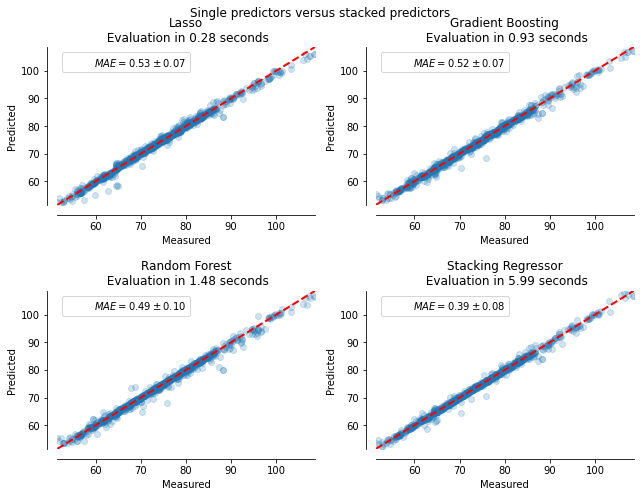

Total run time in 19.92 seconds


In [15]:
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, cross_val_predict

fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)
tic = time.time()
for ax, (name, est) in zip(axs, estimators + [('Stacking Regressor',
                                               stacking_regressor)]):
    start_time = time.time()
    score = cross_validate(est, X, y,
                           scoring=['neg_mean_absolute_error'],
                           n_jobs=-1, verbose=0)
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, X, y, n_jobs=-1, verbose=0)

    plot_regression_results(
        ax, y, y_pred,
        name,
        (r'$MAE={:.2f} \pm {:.2f}$')
        .format(-np.mean(score['test_neg_mean_absolute_error']),
                np.std(score['test_neg_mean_absolute_error'])),
        elapsed_time)
toc = time.time()
plt.suptitle('Single predictors versus stacked predictors')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()
print("Total run time in {:.2f} seconds".format(toc-tic))

# Xtreme Random Forest

In [13]:
from sklearn.metrics import mean_absolute_error
import time

xrf_pipeline = make_pipeline(processor_nlin,
                            ExtraTreesRegressor(random_state=1, 
                                                n_jobs=-1, max_depth=50))

# fit 
tic = time.time()
xrf_pipeline.fit(X_train, y_train)
toc = time.time()

# predict
y_pred = xrf_pipeline.predict(X_test)

In [14]:
print("Training time: {:.2f} mins".format((toc-tic)/60.0))
print("MAE = {:.4f}".format(mean_absolute_error(y_pred, y_test)))

Training time: 2.02 mins
MAE = 0.0028


# Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

xrf_pipeline = make_pipeline(processor_nlin,
                            ExtraTreesRegressor(random_state=1, n_jobs=-1))

# Create parameter grid
random_grid = {'extratreesregressor__n_estimators': [100, 200, 300, 400, 500],
               'extratreesregressor__max_features': ['auto', 'sqrt'],
               'extratreesregressor__max_depth': [np.arange(10,110,10), None],
               'extratreesregressor__min_samples_split': [2, 5, 10, 20],
               'extratreesregressor__min_samples_leaf': [1, 2, 4, 8]}

# perform random grid search that maximizes MAE
randomCV_xrf = RandomizedSearchCV(xrf_pipeline, 
                              param_distributions=random_grid, 
                              n_iter=40, # 20 samples
                              cv=3, # 3 folds
                              scoring="neg_mean_absolute_error",
                              n_jobs=-1, 
                              verbose=1)

# fit the model
randomCV_xrf.fit(X_train, y_train);

# display the best hyper parameters found
randomCV_xrf.best_params_

In [18]:
randomCV_xrf.best_params_

{'extratreesregressor__n_estimators': 500,
 'extratreesregressor__min_samples_split': 2,
 'extratreesregressor__min_samples_leaf': 1,
 'extratreesregressor__max_features': 'auto',
 'extratreesregressor__max_depth': 90}